In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, make_scorer
from bayes_opt import BayesianOptimization

1) The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
login_df = pd.read_json('logins.json')
print(login_df.head())
print('')
print(login_df.dtypes)

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

login_time    datetime64[ns]
dtype: object


In [3]:
login_df['login_time'] = login_df['login_time'].apply(lambda x: x.replace(minute = int(np.floor(x.minute/15)*15), second = 0))
login_df['count'] = 1
print(login_df.head(10))

           login_time  count
0 1970-01-01 20:00:00      1
1 1970-01-01 20:15:00      1
2 1970-01-01 20:15:00      1
3 1970-01-01 20:15:00      1
4 1970-01-01 20:15:00      1
5 1970-01-01 20:15:00      1
6 1970-01-01 20:00:00      1
7 1970-01-01 20:30:00      1
8 1970-01-01 20:30:00      1
9 1970-01-01 20:45:00      1


In [4]:
login_df = login_df.groupby('login_time').agg('sum')
login_df.reset_index(drop=False, inplace=True)
login_df['date'] = login_df['login_time'].apply(lambda x: x.date())
login_df['time'] = login_df['login_time'].apply(lambda x: x.hour*100 + x.minute*25/15)
login_df['day_of_week'] = login_df['login_time'].apply(lambda x: x.weekday())
print(login_df.head(10))

           login_time  count        date    time  day_of_week
0 1970-01-01 20:00:00      2  1970-01-01  2000.0            3
1 1970-01-01 20:15:00      6  1970-01-01  2025.0            3
2 1970-01-01 20:30:00      9  1970-01-01  2050.0            3
3 1970-01-01 20:45:00      7  1970-01-01  2075.0            3
4 1970-01-01 21:00:00      1  1970-01-01  2100.0            3
5 1970-01-01 21:15:00      4  1970-01-01  2125.0            3
6 1970-01-01 21:45:00      4  1970-01-01  2175.0            3
7 1970-01-01 22:00:00      9  1970-01-01  2200.0            3
8 1970-01-01 22:15:00      8  1970-01-01  2225.0            3
9 1970-01-01 22:30:00      1  1970-01-01  2250.0            3


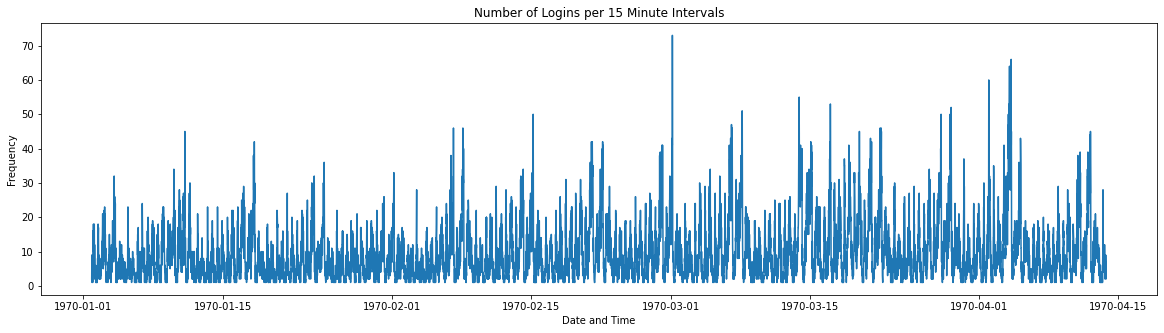

In [5]:
plt.figure(figsize=([20, 5]))
plt.plot('login_time', 'count', data=login_df)
plt.title('Number of Logins per 15 Minute Intervals')
plt.xlabel('Date and Time')
plt.ylabel('Frequency')
plt.show()

There seems to be a repeating pattern in the graph above, but it's hard to visualize what time of day each of the spikes in activity take place in.  To remedy this, I'll make one graph that looks at the day of the week, and one that looks at the hours of the day.

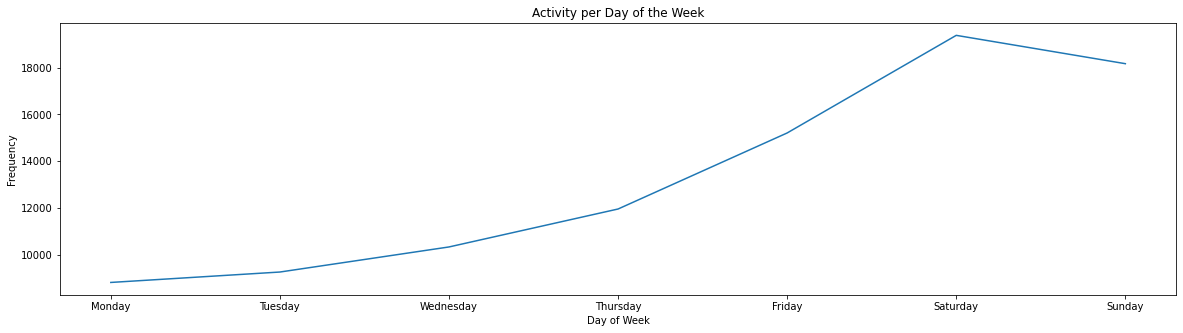

In [6]:
plt.figure(figsize=([20, 5]))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_df = login_df[['day_of_week', 'count']]
week_df = week_df.groupby('day_of_week').agg('sum')
week_df.reset_index(drop=False, inplace=True)
week_df['day_of_week'] = week_df['day_of_week'].apply(lambda x: weekdays[x])

plt.plot('day_of_week', 'count', data=week_df)
plt.title('Activity per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.show()

Looks like the app is significantly more popular on weekends.

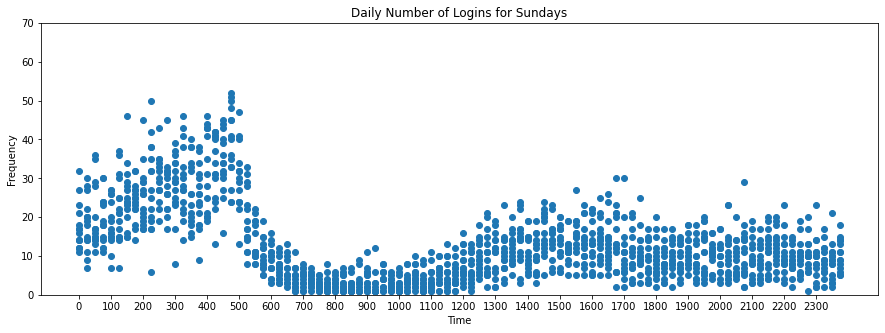

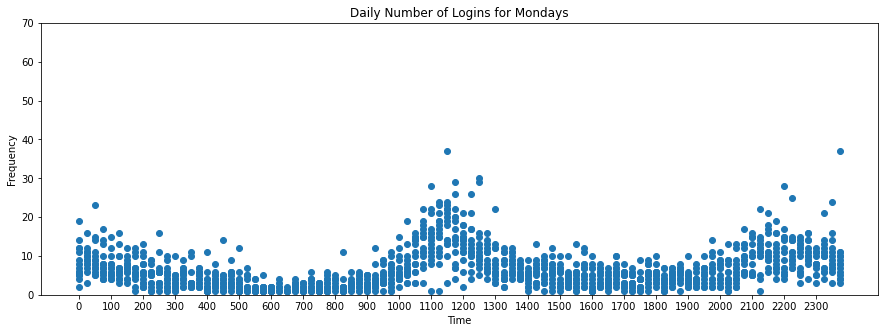

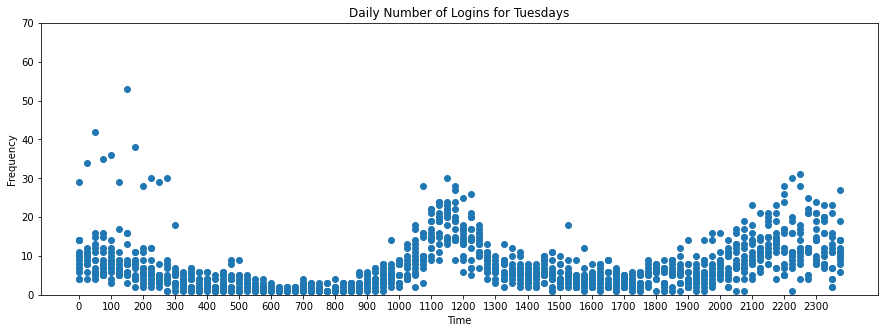

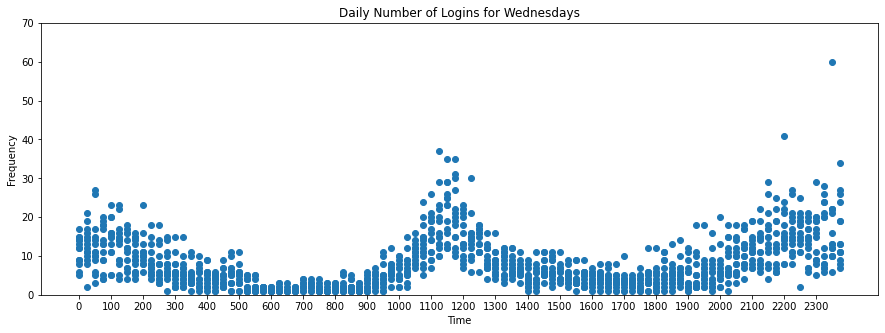

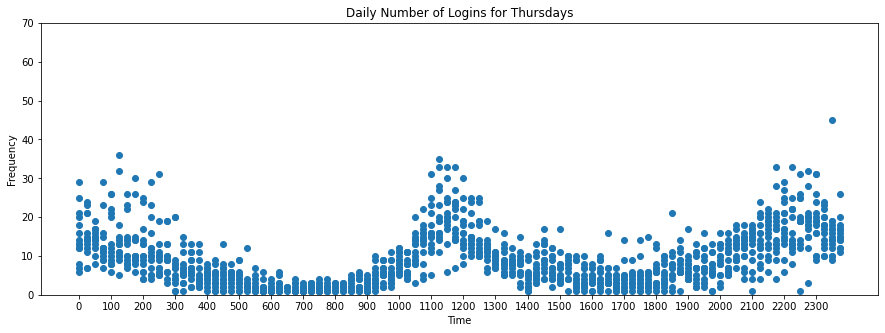

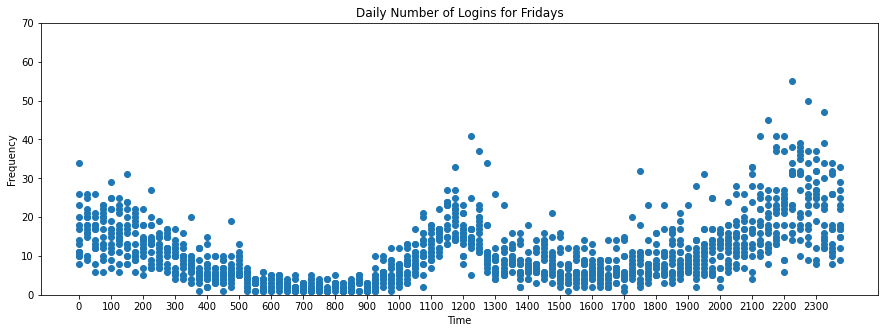

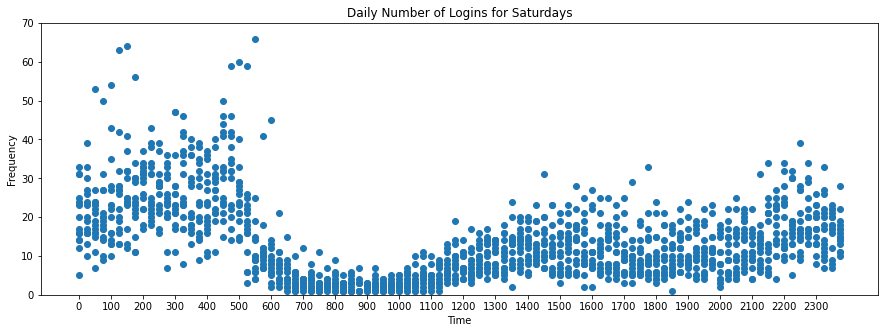

In [7]:
daily_df = login_df[['day_of_week', 'date', 'time', 'count']]

for weekday in [6, 0, 1, 2, 3, 4, 5]:
    plt.figure(figsize=([15, 5]))
    plt.scatter('time', 'count', data=daily_df[daily_df['day_of_week']==weekday])
    
    title = 'Daily Number of Logins for ' + weekdays[weekday] + 's'
    plt.title(title)
    plt.xlabel('Time')
    plt.xticks(np.arange(0, 2400, step=100))
    plt.ylabel('Frequency')
    plt.ylim(0, 70)
    plt.show()

This should make is easier to notice daily patterns.  Monday through Friday follows a moustache shape, where the service frequency peaks around lunchtime and between 9pm and 3am, the latter pattern becoming more extreme as the week progresses, especially on Friday.  Saturday and Sunday are somewhat odd in that they peak around 12am to 5am with an extreme amount of variance, with their evenings becoming progressively less active than Friday.  Looking at these patterns, a reasonable hypothesis would be that on weekdays, the service is mostly being used for grabbing lunch, and then on weekends it becomes increasingly used late at night and early in the morning, which could be the result of weekend parties.




2) The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

If I am to assume we are still only collecting timestamps and not other data, the measure of success that I would use is an increase in activity that would draw more profit than the reimbursed cost of the toll, although this would be much easier to measure if we included the price of each trip.  This is the metric that I would choose, since we would ideally want to not sink money into a solution that nets a loss.  
An experiment I would design to test this is a trial period where for one month, the toll is reimbursed.  Then, I could run a T-test on that data to compare its mean to the prior data to see if there is a significant enough increase to cover the cost of the toll.  One major caveat to this is with only 4 months of prior data, it's very possible that the month of the year has an impact on how often people use the service, which we would not be able to easily discern from a change based on the covered toll cost.  For example, our given dataset runs from January to April, and I imagine that there would be an increase in activity during summer, when people are out of school or going on vacation more frequently.

3) Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


In [8]:
retention_df = pd.read_json('ultimate_data_challenge.json')
print(retention_df.head())
print('')
print(retention_df.dtypes)

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

In [9]:
for column in retention_df.columns:
    print(retention_df[column].unique())

["King's Landing" 'Astapor' 'Winterfell']
[  4   0   3   9  14   2   1   6  24   5   7  11  73   8  10  22  15  13
  17  20  12  42  27  26  18  16  40  28  19  23  33  48  31  71  25  21
  34  29  30  32  47  37  53  43  44  38  39  49  55 125  41  50  63  35
  54  56  36  51  58]
['2014-01-25' '2014-01-29' '2014-01-06' '2014-01-10' '2014-01-27'
 '2014-01-09' '2014-01-24' '2014-01-28' '2014-01-21' '2014-01-03'
 '2014-01-13' '2014-01-15' '2014-01-11' '2014-01-12' '2014-01-02'
 '2014-01-31' '2014-01-19' '2014-01-16' '2014-01-26' '2014-01-05'
 '2014-01-17' '2014-01-22' '2014-01-18' '2014-01-20' '2014-01-04'
 '2014-01-30' '2014-01-07' '2014-01-01' '2014-01-08' '2014-01-23'
 '2014-01-14']
[4.7 5.  4.3 4.6 4.4 3.5 nan 4.5 4.  3.9 4.9 4.8 2.5 3.7 1.  4.1 4.2 3.
 3.8 2.  2.7 3.3 2.8 3.6 3.4 3.2 2.6 3.1 2.9 1.7 1.8 1.5 2.3 1.9 2.1 2.4
 1.6 2.2]
[1.1  1.   1.14 1.19 1.38 1.21 1.17 1.02 1.05 1.5  2.   1.25 1.04 1.88
 1.33 1.56 1.06 1.03 1.09 1.35 3.5  1.11 1.63 2.5  1.32 1.3  1.75 2.25
 1.2  1.1

Of the following columns:

city looks good.

trips_in_first_30_days has no null values, but as the code below points out is it very skewed data.

signup_date looks good, as there are no null values and exclusively January dates.

avg_rating_of_driver has 8122 null values, as shown below.

It depends on what avg_surge represents, but it is odd that most values are between 1 and 2, yet goes up to 8.

last_trip_date looks okay, there are no null values or dates that don't make sense, and the code below shows that there are no last trip dates that predate a user's account.

phone has null values in the form of None, although this could be representing people who didn't use one of those brands for the service.

It depends on what surge_pct represents, but it looks like all values are between 0 and 100 with no nulls.

ultimate_black_user makes sense, assuming it's a boolean representing people who have an upgraded plan.

It depends on what weekday_pct represents, but it runs 0 to 100 with no nulls just like surge_pct.

avg_dist is very skewed, as well as having some 0's which probably represents people who signed up but didn't use the service.

avg_rating_by_driver has 201 nulls, as shown below.

In [10]:
print(retention_df['trips_in_first_30_days'].describe())
print('')
print(retention_df[['signup_date', 'last_trip_date']][retention_df['signup_date'] > retention_df['last_trip_date']])
print('')
print(retention_df['city'][retention_df['avg_rating_of_driver'].isnull()].count())
print('')
print(retention_df['city'][retention_df['avg_rating_by_driver'].isnull()].count())
print('')
print(retention_df['avg_dist'].describe())
print(retention_df['city'][retention_df['avg_dist'].isnull()].count())

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

Empty DataFrame
Columns: [signup_date, last_trip_date]
Index: []

8122

201

count    50000.000000
mean         5.796827
std          5.707357
min          0.000000
25%          2.420000
50%          3.880000
75%          6.940000
max        160.960000
Name: avg_dist, dtype: float64
0


In [11]:
#Fixing phone's None values
cleaned_df = retention_df
cleaned_df['phone'] = cleaned_df['phone'].fillna('Other')
print(cleaned_df['phone'].unique())

['iPhone' 'Android' 'Other']


In [12]:
#Looking at avg_dist == 0 to make sure it's not fake/inactive accounts
print(cleaned_df[cleaned_df['avg_dist']==0])

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
72        Astapor                       1  2014-01-07                   5.0   
116    Winterfell                       1  2014-01-10                   5.0   
188    Winterfell                       1  2014-01-11                   NaN   
356    Winterfell                       1  2014-01-15                   4.0   
479    Winterfell                       1  2014-01-24                   5.0   
...           ...                     ...         ...                   ...   
47929  Winterfell                       0  2014-01-07                   4.0   
48283  Winterfell                       0  2014-01-18                   NaN   
49464     Astapor                       0  2014-01-03                   5.0   
49989  Winterfell                       1  2014-01-24                   NaN   
49996     Astapor                       1  2014-01-24                   NaN   

       avg_surge last_trip_date    phone  surge_pct

There's only 150 rows with 0 average distance out of around 50,000, so I'm going to drop them, since these could be fake accounts leaving driver reviews and skewing data.

In [13]:
cleaned_df = cleaned_df[cleaned_df['avg_dist'] > 0]
print(cleaned_df['avg_dist'].describe())

count    49850.000000
mean         5.814269
std          5.707059
min          0.010000
25%          2.430000
50%          3.900000
75%          6.960000
max        160.960000
Name: avg_dist, dtype: float64


In [14]:
#replacing null values in driver ratings by mean
of_driver_avg = np.mean(cleaned_df['avg_rating_of_driver'])
by_driver_avg = np.mean(cleaned_df['avg_rating_by_driver'])
cleaned_df['avg_rating_of_driver'].fillna(of_driver_avg, inplace=True)
cleaned_df['avg_rating_by_driver'].fillna(by_driver_avg, inplace=True)

print(cleaned_df['avg_rating_of_driver'][cleaned_df['avg_rating_of_driver'].isna()])
print(cleaned_df['avg_rating_by_driver'][cleaned_df['avg_rating_by_driver'].isna()])

Series([], Name: avg_rating_of_driver, dtype: float64)
Series([], Name: avg_rating_by_driver, dtype: float64)


C:\Users\rlybb\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


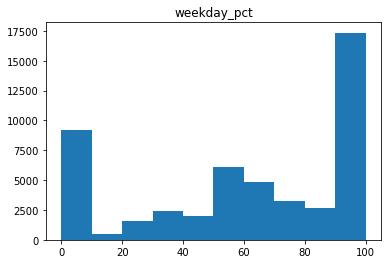

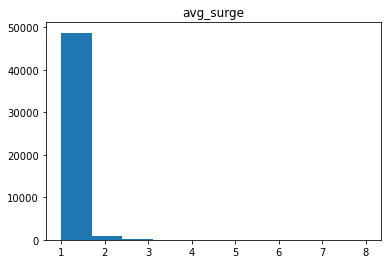

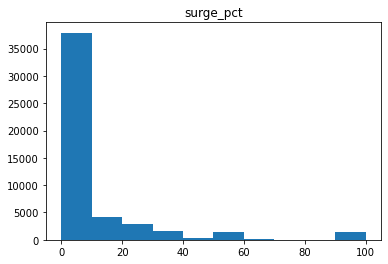

In [15]:
#trying to make sense of pct and surge
plt.hist(cleaned_df['weekday_pct'], bins=10)
plt.title('weekday_pct')
plt.show()
plt.hist(cleaned_df['avg_surge'])
plt.title('avg_surge')
plt.show()
plt.hist(cleaned_df['surge_pct'], bins=10)
plt.title('surge_pct')
plt.show()

Still don't really see what these columns represent, but at least there's not any null values and only avg_surge seems to have outliers.

In [16]:
#adding our prediction value of whether someone has been successfully retained.
cleaned_df = cleaned_df.astype({'signup_date' : 'datetime64', 'last_trip_date': 'datetime64'})

past_month = cleaned_df['last_trip_date'].max()-datetime.timedelta(30)
print(past_month)
cleaned_df['retained'] = cleaned_df['last_trip_date'].apply(lambda x: x >= past_month)
print(cleaned_df['retained'].value_counts())

2014-06-01 00:00:00
False    31061
True     18789
Name: retained, dtype: int64


In [17]:
#adding dummies for phone and city
cleaned_df = pd.get_dummies(data=cleaned_df, columns=['city', 'phone'])
print(cleaned_df.columns)

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_Other', 'phone_iPhone'],
      dtype='object')


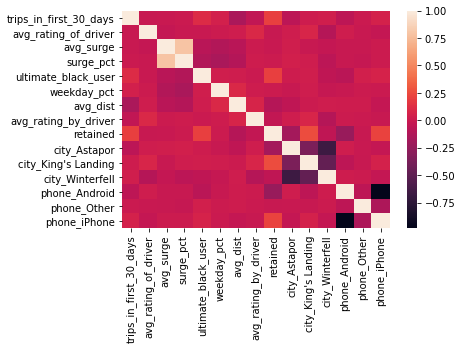

In [18]:
sns.heatmap(cleaned_df.corr())
plt.show()

Not a lot of strong correlations, although it is reassuring that people who take trips in the first 30 days and people who are ultimate black users are the most likely to be retained, as well as people from King's Landing and Iphone users.

Now that we got null values fixed and dummies made, it's time to train, test, split, and model.  Since our target variable is a boolean, a logistic regression model should work well.

In [19]:
X = cleaned_df.drop(columns=['retained', 'signup_date', 'last_trip_date'], inplace=False)
scaler = RobustScaler()
X = scaler.fit_transform(X)
y = cleaned_df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
def cv_score(model, X, y):
    nfold=5
    result = cross_val_score(model, X, y)
    result_sum=0
    for i in result:
        result_sum+=i
    
    return (result_sum/nfold)

In [21]:
def log_reg(input_tol, input_C, input_max_iter):
    lr = LogisticRegression(penalty='l2', tol=input_tol, C=input_C, max_iter=input_max_iter, random_state=1020)
    lr.fit(X_train, y_train)
    return(cv_score(lr, X, y))

In [22]:
optimizer = BayesianOptimization(log_reg, {'input_tol':(0.000001, 1), 'input_C':(0.001, 5), 'input_max_iter':(100, 500)})
optimizer.maximize(n_iter=25, init_points=2)

|   iter    |  target   |  input_C  | input_... | input_tol |
-------------------------------------------------------------
|  1        |  0.7172   |  3.782    |  290.3    |  0.6014   |
|  2        |  0.7172   |  2.145    |  172.0    |  0.7792   |
|  3        |  0.7172   |  1.798    |  173.3    |  0.4603   |
|  4        |  0.7172   |  1.557    |  500.0    |  0.8191   |
|  5        |  0.7172   |  0.3329   |  100.2    |  0.2596   |
|  6        |  0.7172   |  0.1592   |  134.6    |  0.02163  |
|  7        |  0.7172   |  4.923    |  124.2    |  0.6889   |
|  8        |  0.7172   |  0.6125   |  138.8    |  0.1441   |
|  9        |  0.7172   |  4.02     |  134.7    |  0.3327   |
|  10       |  0.718    |  0.0138   |  131.9    |  0.7961   |
|  11       |  0.7172   |  0.8861   |  131.8    |  0.9332   |
|  12       |  0.7172   |  2.248    |  301.3    |  0.06067  |
|  13       |  0.7172   |  1.813    |  416.0    |  0.08713  |
|  14       |  0.7172   |  4.866    |  474.8    |  0.1591   |
|  15   

In [23]:
lr = LogisticRegression(penalty='l2', tol=0.4381, C=0.01549, max_iter=210.6 , random_state=1020)
lr.fit(X_train, y_train)
ypred = lr.predict(X_test)
print(confusion_matrix(ypred, y_test))
print('Accuracy: ', accuracy_score(ypred, y_test))
print('Precision: ', precision_score(ypred, y_test))
print('Recall: ', recall_score(ypred, y_test))

[[6681 2415]
 [1107 2260]]
Accuracy:  0.7174035144026318
Precision:  0.4834224598930481
Recall:  0.6712206712206712


In [39]:
copy_df = cleaned_df.drop(columns=['signup_date', 'last_trip_date', 'retained'])
columns = copy_df.columns
for i in range(len(columns)):
    print(columns[i], '     ', lr.coef_[0][i])

trips_in_first_30_days       0.34999174078322093
avg_rating_of_driver       -0.02750907221154918
avg_surge       -0.013064783870146847
surge_pct       0.04053167252891276
ultimate_black_user       0.8286971856112593
weekday_pct       0.00030387239578986573
avg_dist       -0.1794811132761517
avg_rating_by_driver       -0.05094321608313208
city_Astapor       -0.7277524201572962
city_King's Landing       0.9385789156903679
city_Winterfell       -0.21169635520990768
phone_Android       -0.5125042775326318
phone_Other       -0.039294530323592786
phone_iPhone       0.5517988078562226


My approach to this problem was simply to figure out which columns were highly correlated with retention.  By first building a binary column to reflect retention, it was easier to compare with other columns, and unsurprisingly the columns with higher correlations were better predictors for the model.  I went with a logistic regression model since we were dealing with a few, straightforward columns that fed into a boolean target variable.  The Bayesian Optimizer function I ran didn't improve metrics much, but it was worth a try anyway.  One thing that might potentially throw off the results is the limit of 6 months of data, as we don't get to see metrics for people using the service in the fall and early winter.

This model can be used to increase retention if we pay attention to which of the columns are the best predictors for retention.  People from King's Landing are more likely than their counterparts to stay with the company, as are iPhone users compared to people with other phones.  Ultimate Black users are highly likely to be retained, and the number of trips in the first 30 days is an alright indicator for whether someone stays.  With this knowledge, we can look for signs of what is going right with some metrics and wrong with others.  Maybe the Android app for Ultimate is buggy, or maybe King's Landing has better advertisement.  Additionally, promos could be run to try to get people to use the app more in the first 30 days.